In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
test = np.ones([10, 11], dtype=np.uint8)
test[:3,0] = 0
test[2,1] = 0
test[:2,4:6] = 0

test[4:6,4:6] = 0
test[4:6,1:3] = 0
test[6:7,1:6] = 0

test[7:10,7:10] = 0
test[8,8] = 1
test = 1 - test
test

array([[1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0]], dtype=uint8)

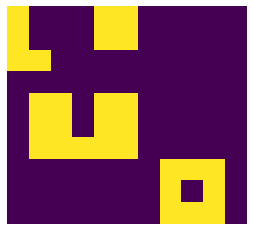

In [10]:
plt.imshow(test)
plt.axis("off")
plt.show()

In [3]:
test.shape

(10, 11)

In [4]:
grps_by_rows = [[]]
g_c = 0
for row in range(test.shape[0]):
    n = 0
    indexes = np.where(test[row] == 1)[0]
    diffs = np.diff(indexes) > 1
    seq = []
    for i in range(indexes.shape[0]):
        seq.append(i)
        if i == 0:
            continue
        if diffs[i-1]:
            # check connectivity or create new group
            group_idexes = [indexes[seq_id] for seq_id in seq[:i]]
            group_idexes = group_idexes*2 if len(group_idexes) == 1 else [()] if group_idexes == [] else group_idexes
            grps_by_rows[row].append((group_idexes[0], group_idexes[-1]))
            n += 1
            seq = seq[i:]
    group_idexes = [indexes[seq_id] for seq_id in seq[:i+1]]
    group_idexes = group_idexes*2 if len(group_idexes) == 1 else [()] if group_idexes == [] else group_idexes
    grps_by_rows[row].append((group_idexes[0], group_idexes[-1]))
    g_c += 1
    grps_by_rows.append([])
grps_by_rows = grps_by_rows[:-1]
grps_by_rows

[[(0, 0), (4, 5)],
 [(0, 0), (4, 5)],
 [(0, 1)],
 [((), ())],
 [(1, 2), (4, 5)],
 [(1, 2), (4, 5)],
 [(1, 5)],
 [(7, 9)],
 [(7, 7), (9, 9)],
 [(7, 9)]]

In [7]:
def check_connectivity(arr, group_borders, row_number, groups_obj):
    """
    must return a group(s) that group_borders belong(s) to.
    """
    if row_number == 0: # create new group as it is row 1
        last_gr_number = list(groups_obj.keys())[-1:]
        last_gr_number = 0 if last_gr_number == [] else last_gr_number[0]+1
        groups_obj.update({last_gr_number: np.array([
            [[row_number,group_borders[0]], [row_number,group_borders[1]]],
        ])
                          })
        return groups_obj
    
    candidates_j_range = [
        group_borders[0]-1 if group_borders[0] != 0 else 0, 
        group_borders[1]+1
    ]
    candidates_i = row_number-1 if row_number != 0 else 0
    canndidates_connect_to = arr[candidates_i,candidates_j_range[0]:candidates_j_range[1]+1]
    if all(canndidates_connect_to == 0):
        last_gr_number = list(groups_obj.keys())[-1:]
        last_gr_number = 0 if last_gr_number == [] else last_gr_number[0]+1
        groups_obj.update({last_gr_number: np.array([
            [[row_number,group_borders[0]], [row_number,group_borders[1]]],
        ])
                          })
        return groups_obj
    group_concatination = [False] * len(groups_obj)
    to_pop = []
    to_drop_duplicates = []
    for j, (k, v) in enumerate(groups_obj.items()):
        for n, element in enumerate(v):
            candidates_j_range_set = set(range(candidates_j_range[0], candidates_j_range[1]+1))
            if element[:,0][0] == candidates_i and set(range(element[:,1][0], element[:,1][1]+1)).intersection(candidates_j_range_set):
                group_concatination[j] = True
                too_ssstak = np.array([[[row_number,group_borders[0]], 
                                        [row_number,group_borders[1]]],
                                         ])
                groups_obj[k] = np.concatenate([groups_obj[k], 
                                                 too_ssstak]
                                                )
                # Concatinate to existing group
                if np.where(group_concatination)[0].shape[0] > 1:
                    to_pop.append(k)
                    gr_concat_to = np.where(group_concatination)[0][0]
                    to_drop_duplicates.append(gr_concat_to)
                    groups_obj[gr_concat_to] = np.concatenate([groups_obj[gr_concat_to], 
                                                               groups_obj[k]])
    if to_pop:
        [groups_obj.pop(pop) for pop in to_pop if pop in groups_obj]
    if to_drop_duplicates:
        [np.unique(groups_obj[dupl], axis=0) for dupl in to_drop_duplicates]
    return groups_obj
        

grps = {}
for r_num, row in enumerate(grps_by_rows):
    for group in row:
        if group == ((), ()):
            continue
        grps = check_connectivity(test, group, r_num, grps)
grps

<ipython-input-7-2bbca1ca6f16>:59: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if group == ((), ()):


{0: array([[[0, 0],
         [0, 0]],
 
        [[1, 0],
         [1, 0]],
 
        [[2, 0],
         [2, 1]]]),
 1: array([[[0, 4],
         [0, 5]],
 
        [[1, 4],
         [1, 5]]]),
 2: array([[[4, 1],
         [4, 2]],
 
        [[5, 1],
         [5, 2]],
 
        [[6, 1],
         [6, 5]],
 
        [[4, 4],
         [4, 5]],
 
        [[5, 4],
         [5, 5]],
 
        [[6, 1],
         [6, 5]]]),
 3: array([[[7, 7],
         [7, 9]],
 
        [[8, 7],
         [8, 7]],
 
        [[8, 9],
         [8, 9]],
 
        [[9, 7],
         [9, 9]],
 
        [[9, 7],
         [9, 9]]])}

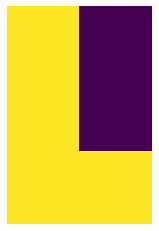

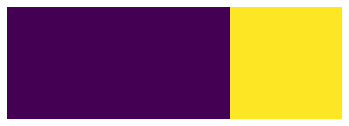

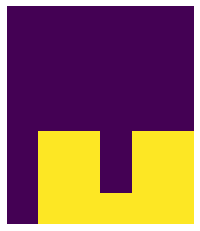

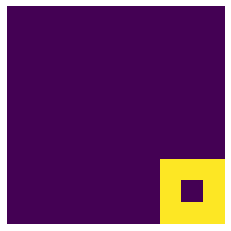

In [30]:

def show_segment(coords):
    max_y = max(coords[:,0,0])
    max_x = max(coords[:,1,1])
    img = np.zeros([max_y+1, max_x+1])
    for border_index in range(coords.shape[0]):
        row = coords[border_index][0][0]
        cols = coords[border_index][:,1]
        cols = cols if cols[1]-cols[0] < 2 else list(range(cols[0], cols[1]+1, 1))
        for col in cols:
            img[row][col] = 1
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    
for i in grps.values():
    show_segment(i)